In [ ]:
!pip install torch torchvision matplotlib
!pip install opencv-python
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.optim as optim
import time
import gc
import torchmetrics

import torchvision.models.detection as detection
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.amp import autocast
import torch.cuda
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models import efficientnet_b3
from torch.amp import GradScaler
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

from torchvision.models.detection.rpn import AnchorGenerator

from tqdm import tqdm

import os
import cv2
import shutil
import time
import zipfile

from collections import defaultdict
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def download_files(file_urls, destination_folder="Dataset_zip",train=True):
  """Downloads multiple files using wget, stores them in a specified folder,
  and renames them sequentially."""

  # Create the destination folder
  os.makedirs(destination_folder, exist_ok=True)

  # Download and rename each file
  for i, url in enumerate(file_urls, 1):  # Start numbering from 1
    # Download the file using wget with a temporary name
    temp_filename = os.path.join(destination_folder, "temp_file")
    os.system(f"wget {url} -O {temp_filename}")

    if train:
    # Construct the new filename (dataset_1, dataset_2, etc.)
      new_filename = os.path.join(destination_folder, f"dataset_{i}")
    else:
      new_filename = os.path.join(destination_folder, f"test_dataset_{i}")
    # Rename the file
    os.rename(temp_filename, new_filename)
    print(f"Downloaded: {new_filename} to {destination_folder}")

In [ ]:
file_urls = [
    "https://entrepot.recherche.data.gouv.fr/api/access/datafile/217981?gbrecs=false",
    "https://entrepot.recherche.data.gouv.fr/api/access/datafile/217976?gbrecs=false",
    "https://entrepot.recherche.data.gouv.fr/api/access/datafile/217974?gbrecs=false",
    "https://entrepot.recherche.data.gouv.fr/api/access/datafile/217980?gbrecs=false",
    "https://entrepot.recherche.data.gouv.fr/api/access/datafile/217970?gbrecs=false",
    "https://entrepot.recherche.data.gouv.fr/api/access/datafile/217975?gbrecs=false",
    "https://entrepot.recherche.data.gouv.fr/api/access/datafile/217971?gbrecs=false",
    "https://entrepot.recherche.data.gouv.fr/api/access/datafile/217978?gbrecs=false"
]

download_files(file_urls, destination_folder="Dataset_zip")

Downloaded: Dataset_zip/dataset_1 to Dataset_zip
Downloaded: Dataset_zip/dataset_2 to Dataset_zip
Downloaded: Dataset_zip/dataset_3 to Dataset_zip
Downloaded: Dataset_zip/dataset_4 to Dataset_zip
Downloaded: Dataset_zip/dataset_5 to Dataset_zip
Downloaded: Dataset_zip/dataset_6 to Dataset_zip
Downloaded: Dataset_zip/dataset_7 to Dataset_zip
Downloaded: Dataset_zip/dataset_8 to Dataset_zip


In [ ]:
def unzip_datasets(zip_dir="Dataset_zip", output_dir="data"):
    """Unzips multiple zip files into individual folders using Python's zipfile module."""
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

    for filename in os.listdir(zip_dir):
            filepath = os.path.join(zip_dir, filename)
            extract_path = os.path.join(output_dir)
            os.makedirs(extract_path, exist_ok=True)

            with zipfile.ZipFile(filepath, 'r') as zip_ref:
                zip_ref.extractall(extract_path)

            print(f"✅ Unzipped: {filename} to {extract_path}")


In [ ]:
unzip_datasets(zip_dir="Dataset_zip", output_dir="data")

✅ Unzipped: dataset_1 to data
✅ Unzipped: dataset_5 to data
✅ Unzipped: dataset_4 to data
✅ Unzipped: dataset_7 to data
✅ Unzipped: dataset_6 to data
✅ Unzipped: dataset_8 to data
✅ Unzipped: dataset_3 to data
✅ Unzipped: dataset_2 to data


In [ ]:
!git clone https://github.com/deel-ai/LARD.git

Cloning into 'LARD'...
remote: Enumerating objects: 475, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 475 (delta 85), reused 56 (delta 56), pack-reused 369 (from 3)
Receiving objects: 100% (475/475), 38.64 MiB | 27.89 MiB/s, done.
Resolving deltas: 100% (219/219), done.


In [ ]:
%cd LARD

/content/LARD


In [ ]:
from src.dataset.lard_dataset import LardDataset

In [ ]:
dataset = LardDataset(train_path="/content/data")

In [ ]:
dataset.export(output_dir ="/content/data_tlbr",
               bbx_format="tlbr", # Options are 'tlbr', 'tlwh', 'xywh', 'corners'
               normalized=False,
               label_file="multiple", # 'multiple' produces 1 file per label, as expected by yolo architectures.
               crop=True, # 'True' recommended to remove the watermark. Pay attention to not crop a picture multiple times
               sep=' ', # Separator in the label file.
               header=False, # 'False' is recommender for multiple files, 'True' for single files. It adds a header with column names in the first line of the labels file
               ext="txt")

------ Exporting train dataset -------
Cropping labels bbox
Converting bboxes to tlbr format
Starting images export
Progress : 0 images on 14433
Progress : 100 images on 14433
Progress : 200 images on 14433
Progress : 300 images on 14433
Progress : 400 images on 14433
Progress : 500 images on 14433
Progress : 600 images on 14433
Progress : 700 images on 14433
Progress : 800 images on 14433
Progress : 900 images on 14433
Progress : 1000 images on 14433
Progress : 1100 images on 14433
Progress : 1200 images on 14433
Progress : 1300 images on 14433
Progress : 1400 images on 14433
Progress : 1500 images on 14433
Progress : 1600 images on 14433
Progress : 1700 images on 14433
Progress : 1800 images on 14433
Progress : 1900 images on 14433
Progress : 2000 images on 14433
Progress : 2100 images on 14433
Progress : 2200 images on 14433
Progress : 2300 images on 14433
Progress : 2400 images on 14433
Progress : 2500 images on 14433
Progress : 2600 images on 14433
Progress : 2700 images on 14433


In [ ]:
%cd ..

/content


In [ ]:
class LARDDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms=None, resize=(1024, 1024),return_original=False):
        self.root_dir = root_dir
        self.return_original = return_original
        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.transforms = transforms
        self.resize = resize  # (width, height)

        # List of image files
        self.image_files = sorted([
            f for f in os.listdir(self.image_dir)
            if f.endswith(".jpeg") or f.endswith(".png")
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size

        # Resize image
        image = image.resize(self.resize)
        new_w, new_h = self.resize

        if self.return_original:
            original_image = image.copy()

        # Compute scale factors
        scale_x = new_w / orig_w
        scale_y = new_h / orig_h

        # Load labels
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(self.label_dir, label_name)

        boxes = []
        labels = []

        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0]) + 1  # shift: 0 (runway) → 1
                labels.append(class_id)
                xmin = float(parts[1]) * scale_x
                ymin = float(parts[2]) * scale_y
                xmax = float(parts[3]) * scale_x
                ymax = float(parts[4]) * scale_y
                boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        assert len(boxes) == len(labels), f"Mismatch in {label_path}"

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            image = self.transforms(image=np.array(image))['image']

        if self.return_original:
            return image, target, original_image
        else:
            return image, target


In [ ]:
transform = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
    # # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=0),
    # A.GaussianBlur(blur_limit=3, p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

dataset = LARDDataset("/content/data_tlbr/train", transforms=transform, resize=(1024, 1024))

In [ ]:
def analyze_boxes(annotation_list):
    """
    Takes a list of bounding boxes in (x_min, y_min, x_max, y_max) format.
    Returns width, height, area, and aspect ratio stats.
    """
    widths, heights = [], []

    for box in annotation_list:
        x_min, y_min, x_max, y_max = box
        w = x_max - x_min
        h = y_max - y_min
        widths.append(w)
        heights.append(h)

    widths = np.array(widths)
    heights = np.array(heights)
    areas = widths * heights
    aspect_ratios = widths / heights

    print("Width stats:", np.percentile(widths, [10, 25, 50, 75, 90]))
    print("Height stats:", np.percentile(heights, [10, 25, 50, 75, 90]))
    print("Area stats:", np.percentile(areas, [10, 25, 50, 75, 90]))
    print("Aspect ratio stats:", np.percentile(aspect_ratios, [10, 25, 50, 75, 90]))

    return widths, heights, areas, aspect_ratios

In [ ]:
train_ratio = 0.8
val_ratio = 1 - train_ratio

# Calculate lengths
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
def get_faster_rcnn_model(num_classes=2, use_custom_backbone=False, custom_backbone_path=None):
    """
    Loads a Faster R-CNN model with optional custom ResNet-50 backbone.

    Args:
        num_classes (int): Number of output classes including background.
        use_custom_backbone (bool): If True, will load custom backbone weights.
        custom_backbone_path (str): Path to the custom backbone weights (if any).

    Returns:
        model (torch.nn.Module): Faster R-CNN model.
    """
    # Load base model
    model = detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT')

    # Optional: Replace the backbone with a custom pretrained one
    if use_custom_backbone and custom_backbone_path:
        print("📦 Loading custom backbone weights from:", custom_backbone_path)
        state_dict = torch.load(custom_backbone_path)
        model.backbone.body.load_state_dict(state_dict)

    # Replace the head for our number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Use torchvision.models.detection.faster_rcnn.FastRCNNPredictor instead of detection.FastRCNNPredictor
    model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
def train_model(model, train_loader, val_loader, device, optimizer=None, num_epochs=10, lr=1e-5):
    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        # Training
        with tqdm(total=len(train_loader), desc=f"🔁 Epoch {epoch+1}/{num_epochs}", leave=True, dynamic_ncols=True) as pbar:
            for images, targets in train_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                with autocast('cuda'):
                    loss_dict = model(images, targets)
                    loss = sum(loss for loss in loss_dict.values())

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

                running_loss += loss.item()
                avg_loss = running_loss / (pbar.n + 1)
                pbar.set_postfix(train_loss=f"{avg_loss:.4f}")
                pbar.update(1)

        # Evaluation
        if (epoch + 1) % 5 == 0:
            model.eval()
            metric = MeanAveragePrecision()
            with torch.no_grad():
                for images, targets in val_loader:
                    images = [img.to(device) for img in images]
                    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                    outputs = model(images)
                    outputs_cpu = [{k: v.cpu() for k, v in o.items()} for o in outputs]
                    targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]

                    metric.update(outputs_cpu, targets_cpu)

            results = metric.compute()
        else:
            results = {'map': torch.tensor(-1.0), 'map_50': torch.tensor(-1.0), 'map_75': torch.tensor(-1.0)}

        epoch_time = time.time() - start_time
        vram_used = torch.cuda.max_memory_allocated(device) / 1024**2

        print(f"\n📅 Epoch [{epoch+1}/{num_epochs}] Summary:")
        print(f"🔧 Train Loss:       {running_loss / len(train_loader):.4f}")
        print(f"📈 mAP:              {results['map']:.4f}")
        print(f"🎯 mAP@0.5 (P):      {results['map_50']:.4f}")
        print(f"📏 mAP@0.75 (R):     {results['map_75']:.4f}")
        print(f"🕒 Time:             {epoch_time:.2f}s")
        print(f"🧠 VRAM Used:        {vram_used:.2f} MB")

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': running_loss / len(train_loader),
            'map': results['map'].item()
        }, f"checkpoint_epoch_{epoch+1}.pth")
        print(f"💾 Model checkpoint saved: checkpoint_epoch_{epoch+1}.pth")

        torch.cuda.reset_max_memory_allocated(device)
        torch.cuda.empty_cache()
        gc.collect()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_faster_rcnn_model(num_classes=2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 120MB/s]


In [ ]:
train_model(model, train_loader, val_loader, device, num_epochs=10)

🔁 Epoch 1/10: 100%|██████████| 1925/1925 [45:59<00:00,  1.43s/it, train_loss=0.0556]



📅 Epoch [1/10] Summary:
🔧 Train Loss:       0.0556
📈 mAP:              -1.0000
🎯 mAP@0.5 (P):      -1.0000
📏 mAP@0.75 (R):     -1.0000
🕒 Time:             2759.21s
🧠 VRAM Used:        4975.88 MB
💾 Model checkpoint saved: checkpoint_epoch_1.pth


🔁 Epoch 2/10: 100%|██████████| 1925/1925 [45:32<00:00,  1.42s/it, train_loss=0.0242]



📅 Epoch [2/10] Summary:
🔧 Train Loss:       0.0242
📈 mAP:              -1.0000
🎯 mAP@0.5 (P):      -1.0000
📏 mAP@0.75 (R):     -1.0000
🕒 Time:             2732.90s
🧠 VRAM Used:        4779.27 MB
💾 Model checkpoint saved: checkpoint_epoch_2.pth


🔁 Epoch 3/10: 100%|██████████| 1925/1925 [45:32<00:00,  1.42s/it, train_loss=0.0185]



📅 Epoch [3/10] Summary:
🔧 Train Loss:       0.0185
📈 mAP:              -1.0000
🎯 mAP@0.5 (P):      -1.0000
📏 mAP@0.75 (R):     -1.0000
🕒 Time:             2732.13s
🧠 VRAM Used:        4779.27 MB
💾 Model checkpoint saved: checkpoint_epoch_3.pth


🔁 Epoch 4/10: 100%|██████████| 1925/1925 [45:38<00:00,  1.42s/it, train_loss=0.0152]



📅 Epoch [4/10] Summary:
🔧 Train Loss:       0.0152
📈 mAP:              -1.0000
🎯 mAP@0.5 (P):      -1.0000
📏 mAP@0.75 (R):     -1.0000
🕒 Time:             2738.36s
🧠 VRAM Used:        4779.27 MB
💾 Model checkpoint saved: checkpoint_epoch_4.pth


🔁 Epoch 5/10: 100%|██████████| 1925/1925 [45:29<00:00,  1.42s/it, train_loss=0.0129]



📅 Epoch [5/10] Summary:
🔧 Train Loss:       0.0129
📈 mAP:              0.9249
🎯 mAP@0.5 (P):      0.9901
📏 mAP@0.75 (R):     0.9901
🕒 Time:             3443.15s
🧠 VRAM Used:        4780.78 MB
💾 Model checkpoint saved: checkpoint_epoch_5.pth


🔁 Epoch 6/10: 100%|██████████| 1925/1925 [45:25<00:00,  1.42s/it, train_loss=0.0114]



📅 Epoch [6/10] Summary:
🔧 Train Loss:       0.0114
📈 mAP:              -1.0000
🎯 mAP@0.5 (P):      -1.0000
📏 mAP@0.75 (R):     -1.0000
🕒 Time:             2725.99s
🧠 VRAM Used:        4779.27 MB
💾 Model checkpoint saved: checkpoint_epoch_6.pth


🔁 Epoch 7/10: 100%|██████████| 1925/1925 [45:13<00:00,  1.41s/it, train_loss=0.0104]



📅 Epoch [7/10] Summary:
🔧 Train Loss:       0.0104
📈 mAP:              -1.0000
🎯 mAP@0.5 (P):      -1.0000
📏 mAP@0.75 (R):     -1.0000
🕒 Time:             2713.85s
🧠 VRAM Used:        4779.27 MB
💾 Model checkpoint saved: checkpoint_epoch_7.pth


🔁 Epoch 8/10: 100%|██████████| 1925/1925 [45:18<00:00,  1.41s/it, train_loss=0.0096]



📅 Epoch [8/10] Summary:
🔧 Train Loss:       0.0096
📈 mAP:              -1.0000
🎯 mAP@0.5 (P):      -1.0000
📏 mAP@0.75 (R):     -1.0000
🕒 Time:             2718.16s
🧠 VRAM Used:        4779.27 MB
💾 Model checkpoint saved: checkpoint_epoch_8.pth


🔁 Epoch 9/10: 100%|██████████| 1925/1925 [45:15<00:00,  1.41s/it, train_loss=0.0088]



📅 Epoch [9/10] Summary:
🔧 Train Loss:       0.0088
📈 mAP:              -1.0000
🎯 mAP@0.5 (P):      -1.0000
📏 mAP@0.75 (R):     -1.0000
🕒 Time:             2715.02s
🧠 VRAM Used:        4780.78 MB
💾 Model checkpoint saved: checkpoint_epoch_9.pth


🔁 Epoch 10/10: 100%|██████████| 1925/1925 [44:57<00:00,  1.40s/it, train_loss=0.0082]



📅 Epoch [10/10] Summary:
🔧 Train Loss:       0.0082
📈 mAP:              0.9474
🎯 mAP@0.5 (P):      0.9901
📏 mAP@0.75 (R):     0.9901
🕒 Time:             3399.89s
🧠 VRAM Used:        4779.79 MB
💾 Model checkpoint saved: checkpoint_epoch_10.pth


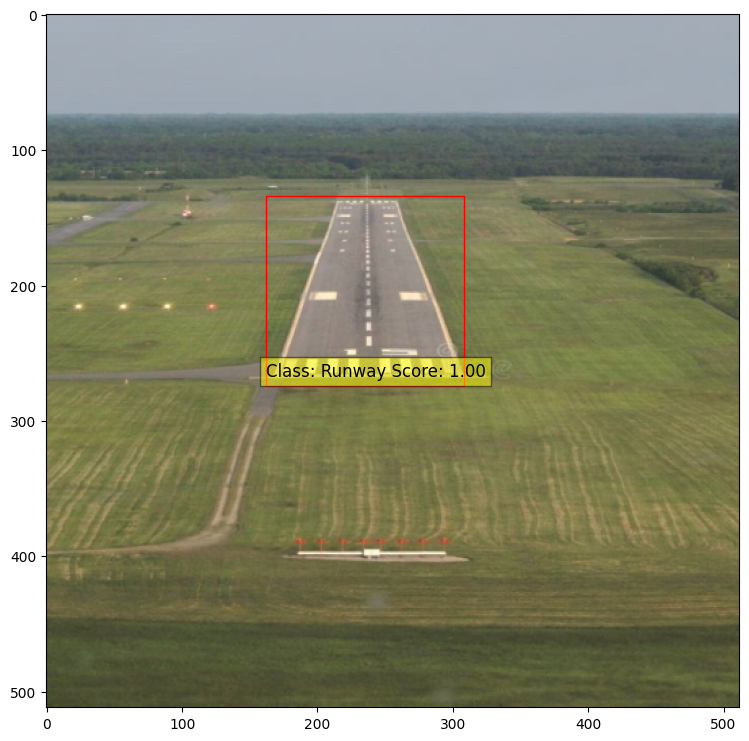

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

img_path = "/content/aerial-view-runway-dusk-final-ap.jpg"
img = Image.open(img_path)

# Transform the image
img1=transform(img)
input_img = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Put the model in evaluation mode
model.eval()

# Run the image through the model
with torch.no_grad():
    prediction = model(input_img)

# Visualize the image and the predicted bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 9))
img1 = img1.permute(1, 2, 0).cpu().numpy()

ax.imshow(img1)

# Get the predicted boxes and labels
boxes = prediction[0]['boxes'].cpu().numpy()  # Get boxes from prediction
labels = prediction[0]['labels'].cpu().numpy()  # Get labels from prediction
scores = prediction[0]['scores'].cpu().numpy()  # Get confidence scores

# Draw the bounding boxes
for i, box in enumerate(boxes):
    if scores[i] > 0.5:  # Only draw boxes with high confidence
        x1, y1, x2, y2 = box
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   fill=False, color='red', linewidth=1))
        ax.text(x1, y1+y1, f'Class: Runway Score: {scores[i]:.2f}',
                bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12)

plt.show()

In [ ]:
torch.save(model.state_dict(), "fasterrcnn_runway.pth")


In [ ]:
file_urls=['https://entrepot.recherche.data.gouv.fr/api/access/datafile/217972?gbrecs=false']
download_files(file_urls, destination_folder="test_Dataset_zip",train=False)

Downloaded: test_Dataset_zip/test_dataset_1 to test_Dataset_zip


In [ ]:
unzip_datasets(zip_dir="test_Dataset_zip", output_dir="Test_data")

✅ Unzipped: test_dataset_1 to Test_data


In [ ]:
dataset = LardDataset(test_path="/content/Test_data/LARD_test_real")

In [ ]:
dataset.export(output_dir ="/content/data_tlbr",
               bbx_format="tlbr", # Options are 'tlbr', 'tlwh', 'xywh', 'corners'
               normalized=False,
               label_file="multiple", # 'multiple' produces 1 file per label, as expected by yolo architectures.
               crop=True, # 'True' recommended to remove the watermark. Pay attention to not crop a picture multiple times
               sep=' ', # Separator in the label file.
               header=False, # 'False' is recommender for multiple files, 'True' for single files. It adds a header with column names in the first line of the labels file
               ext="txt")

------ Exporting test dataset -------
Cropping labels bbox
Converting bboxes to tlbr format
Starting images export
Progress : 0 images on 1811
Progress : 100 images on 1811
Progress : 200 images on 1811
Progress : 300 images on 1811
Progress : 400 images on 1811
Progress : 500 images on 1811
Progress : 600 images on 1811
Progress : 700 images on 1811
Progress : 800 images on 1811
Progress : 900 images on 1811
Progress : 1000 images on 1811
Progress : 1100 images on 1811
Progress : 1200 images on 1811
Progress : 1300 images on 1811
Progress : 1400 images on 1811
Progress : 1500 images on 1811
Progress : 1600 images on 1811
Progress : 1700 images on 1811
Progress : 1800 images on 1811


In [ ]:
test_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [ ]:
test_dataset=LARDDataset("/content/data_tlbr/test", transforms=test_transform, resize=(1024, 1024),return_original=True)

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_faster_rcnn_model(num_classes=2)
checkpoint = torch.load("/content/checkpoint_epoch_10.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [ ]:
def visualize_predictions(image, target, prediction):
    """Visualizes the image with ground truth and predicted bounding boxes."""
    # image = image.permute(1, 2, 0).cpu().numpy()  # Convert image to numpy array
    # image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    # image = np.clip(image, 0, 1)
    # image = (image * 255).astype(np.uint8)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Create two subplots
    ax[0].imshow(image)  # Show the image
    ax[1].imshow(image)  # Show the image

    # Ground truth boxes
    gt_boxes = target['boxes'].cpu().numpy()
    for box in gt_boxes:
        x1, y1, x2, y2 = box
        ax[0].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       fill=False, color='green', linewidth=2))  # Green for ground truth

    # Predicted boxes
    pred_boxes = prediction['boxes'].cpu().numpy()
    pred_scores = prediction['scores'].cpu().numpy()
    for i, box in enumerate(pred_boxes):
        score = pred_scores[i]
        if score > 0.5:
            x1, y1, x2, y2 = box
            ax[1].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                          fill=False, color='red', linewidth=2))
            ax[1].text(x1, y1, f'{score:.2f}', color='red', fontsize=8)  # Red for predictions

    ax[0].set_title("Ground Truth")
    ax[1].set_title("Predictions")
    plt.show()

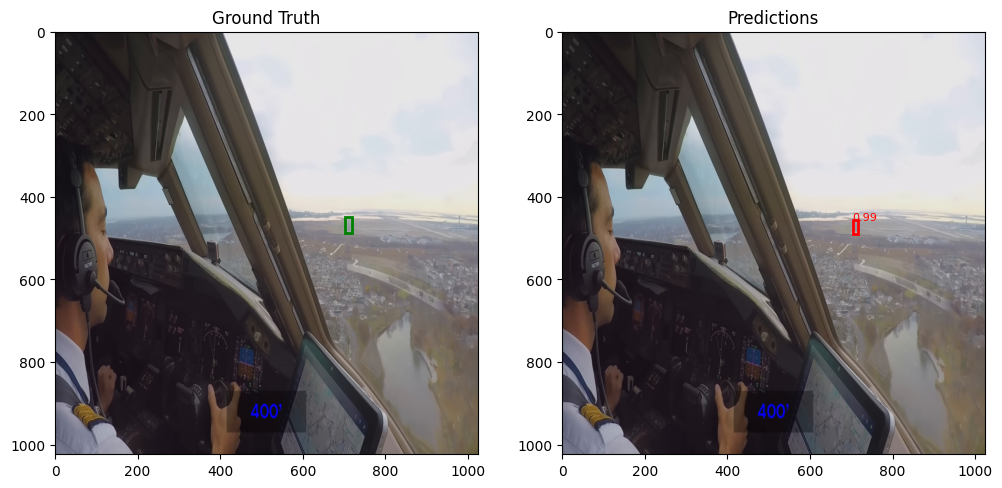

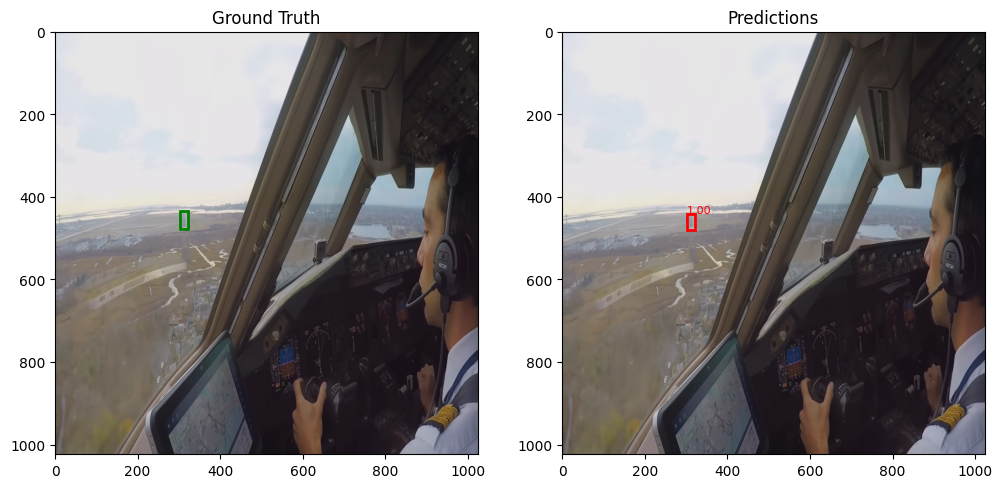

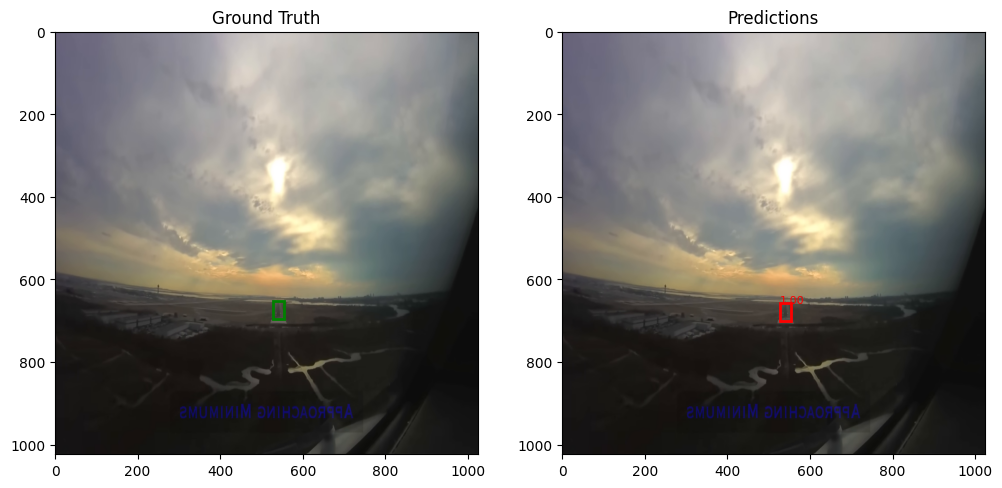

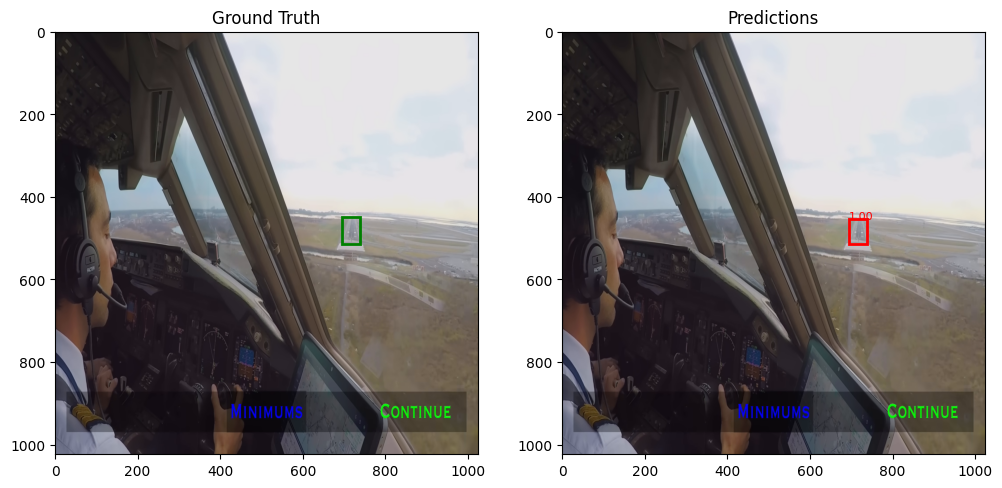

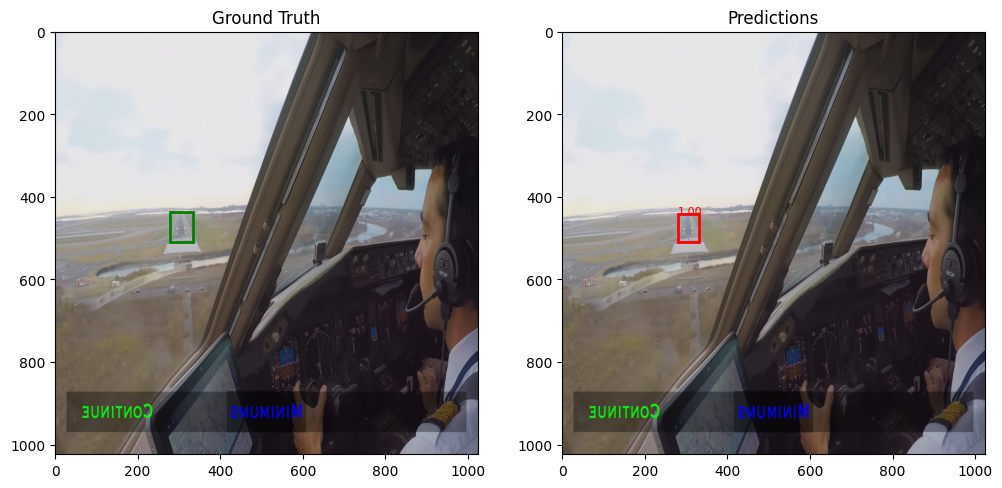

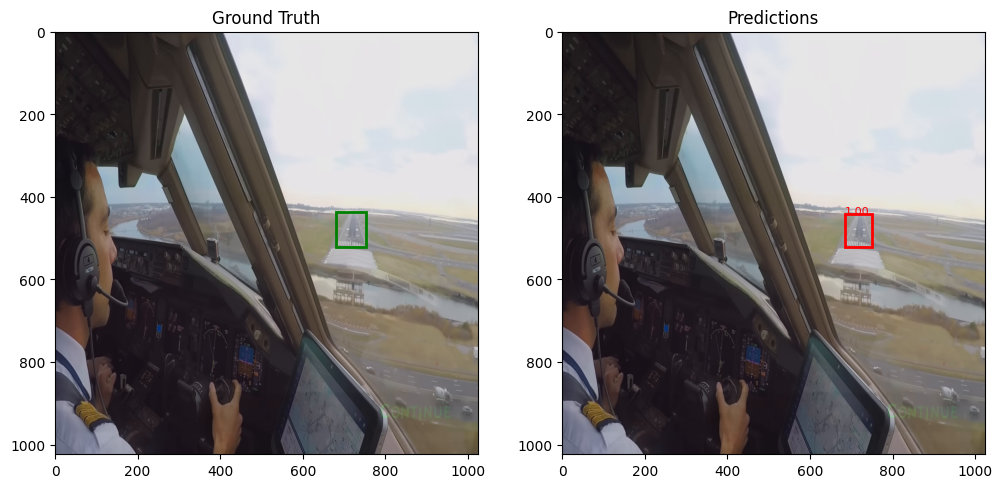

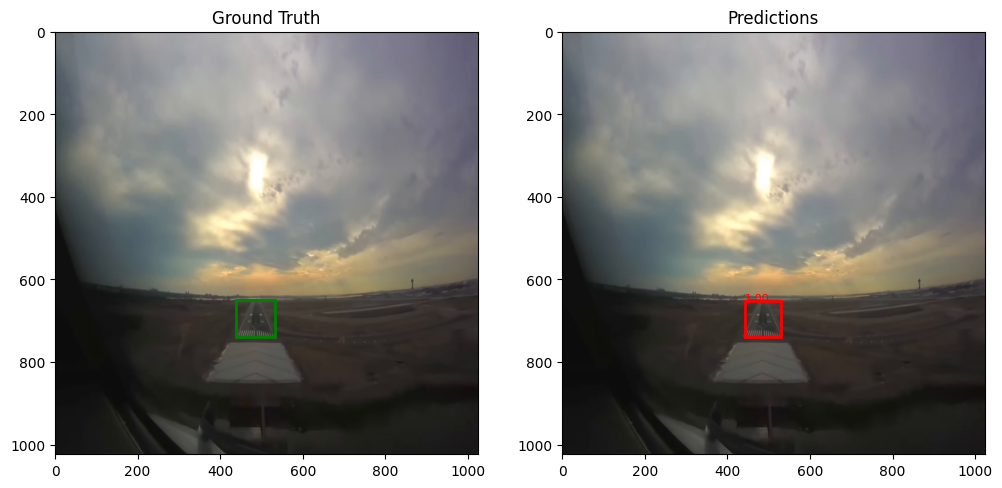

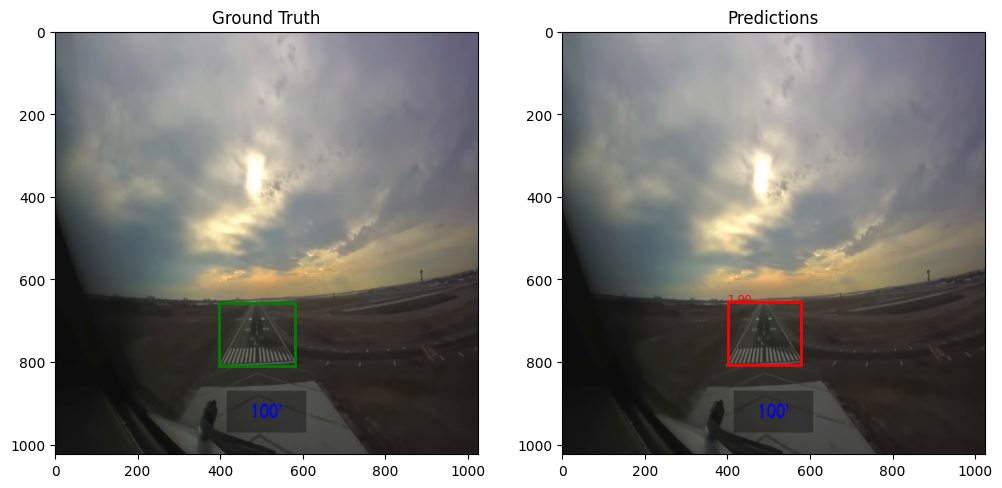

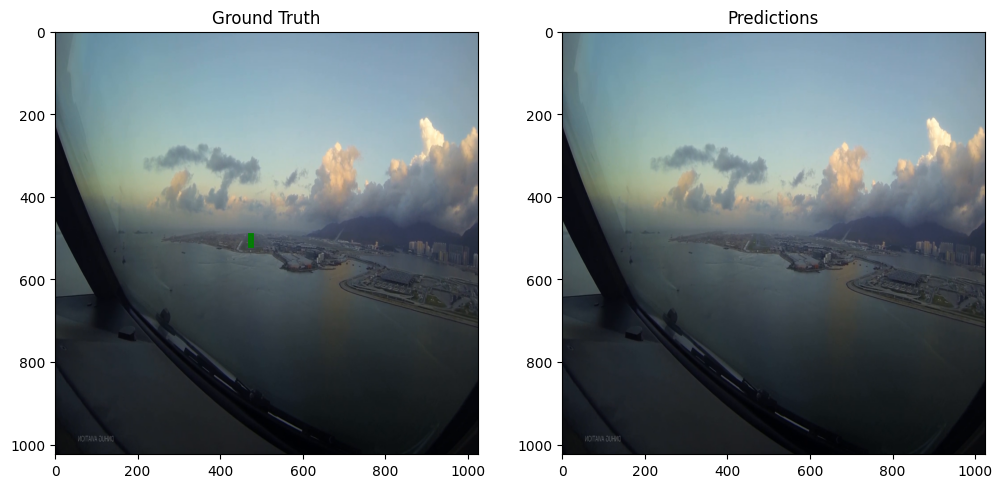

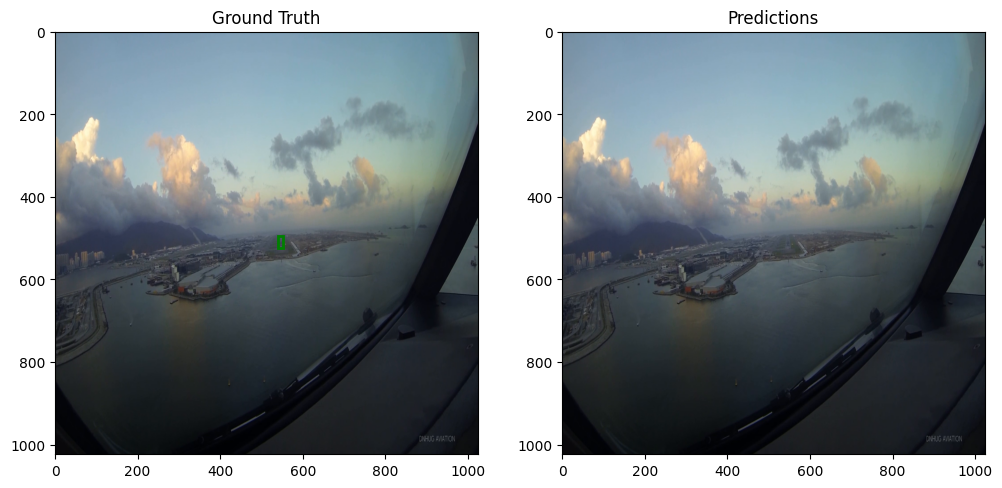

{'map': tensor(0.5974), 'map_50': tensor(0.8045), 'map_75': tensor(0.6918), 'map_small': tensor(0.3088), 'map_medium': tensor(0.6905), 'map_large': tensor(0.8287), 'mar_1': tensor(0.6236), 'mar_10': tensor(0.6279), 'mar_100': tensor(0.6279), 'mar_small': tensor(0.3559), 'mar_medium': tensor(0.7271), 'mar_large': tensor(0.8565), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(1, dtype=torch.int32)}


In [ ]:
metric = MeanAveragePrecision()
num_visualizations = 0

with torch.no_grad():
    for images,targets,original_image in test_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)
        outputs_cpu = [{k: v.cpu() for k, v in o.items()} for o in outputs]
        targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]

        metric.update(outputs_cpu, targets_cpu)
        for i in range(len(images)):
            if num_visualizations >= 10:
                break
            # print(outputs_cpu[i]['boxes'])
            visualize_predictions(original_image[i], targets[i], outputs[i])
            num_visualizations += 1

results = metric.compute()
print(results)